In [27]:
import os
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import final_project.config as c
from final_project.models.DataBase import DataBase
from final_project.models.Matcher import Matcher
from final_project.models.Frame import Frame

colorblind_friendly = ["#762a83", "#de77ae", "gold", "cyan", "#1b7837"]

In [2]:
db = DataBase([])
tracks = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "tracks.pkl"))
cameras = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "pnp_cameras.pkl"))
db._tracks_db = tracks
print(tracks.shape)
print(cameras.shape)

(924501, 3)
(3450,)


In [14]:
frames = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "pnp_frames.pkl"))
print(frames.shape)
frames.head()

(3450,)


FrameIdx
0    Fr0
1    Fr1
2    Fr2
3    Fr3
4    Fr4
Name: Frame, dtype: object

Table 3

In [30]:
def measure_inliers_within_frame(n: int, m: Matcher, verbose=False):
    assert 0 < n <= c.NUM_FRAMES
    strt = time.time()

    match_count = np.zeros(n)
    feature_count = np.zeros(n)
    for i in range(n):
        img_l, img_r = c.read_images(i)
        kps_l, descs_l = m._detector.detectAndCompute(img_l, None)
        kps_r, descs_r = m._detector.detectAndCompute(img_r, None)
        all_matches = m.match_descriptors(descs_l, descs_r)
        features, descriptors = m._find_frame_inliers(kps_l, kps_r, descs_l, all_matches)
        match_count[i] = len(all_matches)
        feature_count[i] = len(features)
        if i%500==0 and verbose:
            elapsed = time.time() - strt
            print(f"\tFinished {i} Frames in {elapsed:.2f} seconds")

    elpsd = time.time() - strt
    return match_count, feature_count, elpsd

In [31]:
m0 = Matcher(detector_type=c.DEFAULT_DETECTOR_NAME, matcher_type=c.DEFAULT_MATCHER_NAME, use_crosscheck=c.SHOULD_CROSS_CHECK, use_2nn=c.SHOULD_USE_2NN)
match_count0, feature_count0, elapsed0 = measure_inliers_within_frame(c.NUM_FRAMES, m0, verbose=True)
print(f"Finished m0 in {(elapsed0/60):.2f} minutes\n")
len(match_count0), len(feature_count0)

	Finished 0 Frames in 0.24 seconds
	Finished 500 Frames in 149.53 seconds
	Finished 1000 Frames in 344.41 seconds
	Finished 1500 Frames in 523.96 seconds
	Finished 2000 Frames in 732.19 seconds
	Finished 2500 Frames in 945.68 seconds
	Finished 3000 Frames in 1104.16 seconds
Finished m0 in 20.57 minutes



(3450, 3450)

In [32]:
start = time.time()

print(f"Frame Count:\t{len(tracks.index.unique(level=c.FrameIdx))}")
print(f"Tracks Count:\t{len(tracks.index.unique(level=c.TrackIdx))}")

frame_matches = pd.Series(match_count0, name="FrameMatches")
print(f"Frame Matches:\tMean:{frame_matches.mean():.2f}\tStD:{frame_matches.std():.2f}\tMin:{frame_matches.min():.2f}\tMax:{frame_matches.max():.2f}")

frame_features = frames.apply(lambda f: f.num_features)
print(f"Frame Features:\tMean:{frame_features.mean():.2f}\tStD:{frame_features.std():.2f}\tMin:{frame_features.min():.2f}\tMax:{frame_features.max():.2f}")

frame_tracks = frames.apply(lambda f: len(f._feature_idx_to_track_id))
print(f"Frame Tracks:\tMean:{frame_tracks.mean():.2f}\tStD:{frame_tracks.std():.2f}\tMin:{frame_tracks.min():.2f}\tMax:{frame_tracks.max():.2f}")

frame_links = pd.Series([db.get_shared_tracks(i, i+1).size for i in range(c.NUM_FRAMES - 1)])
print(f"Frame Links:\tMean:{frame_links.mean():.2f}\tStD:{frame_links.std():.2f}\tMin:{frame_links.min():.2f}\tMax:{frame_links.max():.2f}")

track_lengths = db.get_track_lengths()
print(f"Track Length:\tMean:{track_lengths.mean():.2f}\tStD:{track_lengths.std():.2f}\tMin:{track_lengths.min():.2f}\tMax:{track_lengths.max():.2f}")

elapsed = time.time() - start
elapsed

Frame Count:	3450
Tracks Count:	153295
Frame Matches:	Mean:1159.33	StD:408.09	Min:400.00	Max:2758.00
Frame Features:	Mean:774.51	StD:263.20	Min:246.00	Max:1836.00
Frame Tracks:	Mean:510.61	StD:177.35	Min:171.00	Max:1230.00
Frame Links:	Mean:223.60	StD:87.43	Min:54.00	Max:568.00
Track Length:	Mean:6.03	StD:3.04	Min:4.00	Max:65.00


49.714805364608765

Figure 5A

% Long Tracks: 9.72


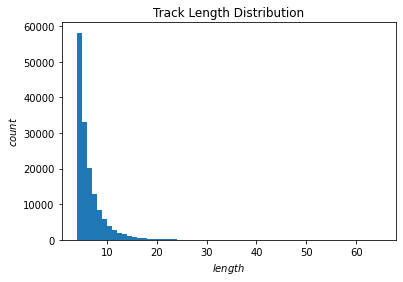

In [52]:
plt.clf()
num_bins = track_lengths.max() - track_lengths.min()
ax = track_lengths.plot.hist(bins=num_bins)
ax.set_xlabel("$length$")
ax.set_ylabel("$count$")
ax.set_title("Track Length Distribution")

print(f"% Long Tracks: {100 * (track_lengths >= 10).sum() / len(track_lengths):.2f}")

plt.show()

Figure 5B

<Figure size 432x288 with 0 Axes>

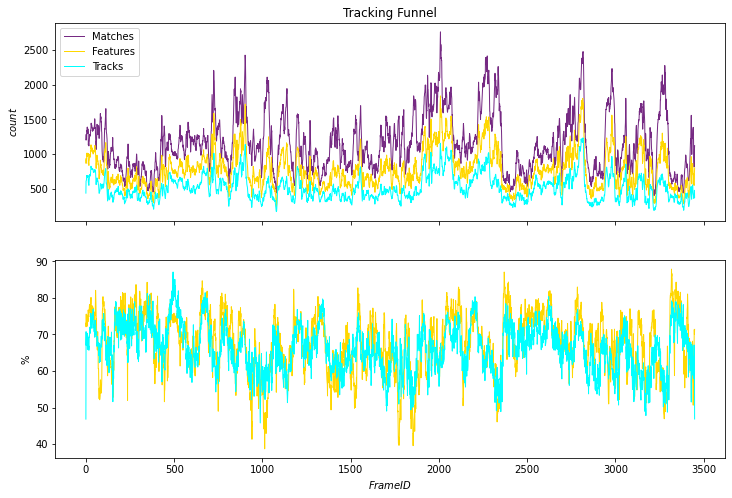

In [73]:
plt.clf()
fig, axes = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(12, 8))

axes[0].set_title("Tracking Funnel")
axes[0].plot(frame_matches.index, frame_matches, label="Matches", c=colorblind_friendly[0], linewidth=1)
axes[0].plot(frame_features.index, frame_features, label="Features", c=colorblind_friendly[2], linewidth=1)
axes[0].plot(frame_tracks.index, frame_tracks, label="Tracks", c=colorblind_friendly[3], linewidth=1)
# axes[0].plot(frame_links.index, frame_links, label="Links", c=colorblind_friendly[1], linewidth=1)
axes[0].set_ylabel("$count$")
axes[0].legend()

axes[1].plot(frame_features.index, 100 * np.divide(frame_features, frame_matches), label="Features", c=colorblind_friendly[2], linewidth=1)
axes[1].plot(frame_tracks.index, 100 * np.divide(frame_tracks, frame_features), label="Tracks", c=colorblind_friendly[3], linewidth=1)
# axes[1].plot(frame_links.index, 100 * np.divide(frame_links, frame_features[:-1]), label="Links", c=colorblind_friendly[3], linewidth=1)
axes[1].set_xlabel("$Frame ID$")
axes[1].set_ylabel("%")

plt.show()

figure 6

In [95]:
start = time.time()

prev = frames[0]
between_matches = np.zeros(len(frames) - 1)
for i, f in enumerate(frames[1:]):
    if i % 340 == 0:
        print(f"finished {i} pairs")
    matches = m0.match_descriptors(prev.descriptors, f.descriptors)
    between_matches[i] = len(matches)

between_matches = pd.Series(between_matches, name="BetweenMatches")
print(f"Between Matches:\tMean:{between_matches.mean():.2f}\tStD:{between_matches.std():.2f}\tMin:{between_matches.min():.2f}\tMax:{between_matches.max():.2f}")

elapsed = time.time() - start
elapsed

finished 0 pairs
finished 340 pairs
finished 680 pairs
finished 1020 pairs
finished 1360 pairs
finished 1700 pairs
finished 2040 pairs
finished 2380 pairs
finished 2720 pairs
finished 3060 pairs
finished 3400 pairs
Between Matches:	Mean:265.03	StD:50.77	Min:114.00	Max:528.00


34.019622564315796

1679
156


<Figure size 432x288 with 0 Axes>

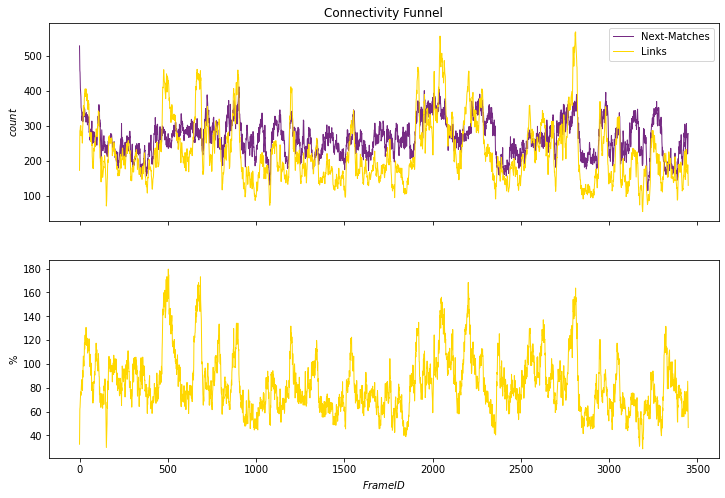

In [124]:
plt.clf()
fig, axes = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(12, 8))

axes[0].set_title("Connectivity Funnel")
axes[0].plot(between_matches.index, between_matches, label="Next-Matches", c=colorblind_friendly[0], linewidth=1)
axes[0].plot(frame_links.index, frame_links, label="Links", c=colorblind_friendly[2], linewidth=1)
axes[0].set_ylabel("$count$")
axes[0].legend()

axes[1].plot(frame_links.index, 100 * np.divide(frame_links, between_matches), label="Links", c=colorblind_friendly[2], linewidth=1)
axes[1].set_xlabel("$Frame ID$")
axes[1].set_ylabel("%")

print((frame_links <= 200).sum())
print((np.divide(frame_links, between_matches) <= 0.5).sum())

plt.show()

436
12.641345317483328%


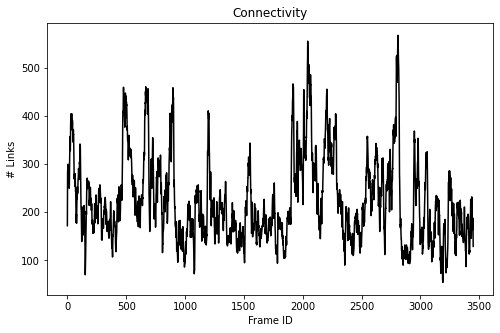

In [129]:
plt.clf()
ax = frame_links.plot.line(figsize=(8, 5), color='k')
ax.set_title("Connectivity")
ax.set_xlabel("Frame ID")
ax.set_ylabel("# Links")

threshold = frame_links.mean() - frame_links.std()
print((frame_links <= threshold).sum())
print(f"{100 * (frame_links <= threshold).sum() / len(frame_links)}%")

plt.show()

In [135]:
frame_links.mean(), frame_links.std(), frame_links.median(), frame_links.quantile(0.2)

(223.60278341548275, 87.43032992536538, 203.0, 153.0)

In [5]:
import os
import pandas as pd

import final_project.config as c
from final_project.models.Camera import Camera

pnp_Rs = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "pnp_R"))
pnp_ts = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "pnp_t"))
ba_Rs = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "ba_R"))
ba_ts = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "ba_t"))
pg_Rs = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "pg_R"))
pg_ts = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "pg_t"))

pnp_cameras = []
ba_cameras = []
pg_cameras = []
for i in range(len(pnp_Rs)):
    pnp_cameras.append(Camera.from_Rt(pnp_Rs[i], pnp_ts[i]))
    ba_cameras.append(Camera.from_Rt(ba_Rs[i], ba_ts[i]))
    if i in pg_Rs.index:
        pg_cameras.append(Camera.from_Rt(pg_Rs[i], pg_ts[i]))


pd.Series(pnp_cameras, index=pnp_Rs.index, name="pnp_cameras").to_pickle(os.path.join(c.DATA_WRITE_PATH, "pnp_cameras.pkl"))
pd.Series(ba_cameras, index=ba_Rs.index, name="ba_cameras").to_pickle(os.path.join(c.DATA_WRITE_PATH, "ba_cameras.pkl"))
pd.Series(pg_cameras, index=pg_Rs.index, name="ba_cameras").to_pickle(os.path.join(c.DATA_WRITE_PATH, "pg_cameras.pkl"))

In [3]:
from final_project.service.InitialEstimateCalculator import IECalc
frames = IECalc().process(min_track_length=4, verbose=True)
s = pd.Series(frames, name="Frame")
s.index.name=c.FrameIdx
s.to_pickle(os.path.join(c.DATA_WRITE_PATH, "pnp_frames.pkl"))

Calculating initial estimates for 3450 Frames...
	Processed 97 tracking-pairs in 1 minutes
	Processed 219 tracking-pairs in 2 minutes
	Processed 353 tracking-pairs in 3 minutes
	Processed 529 tracking-pairs in 4 minutes
	Processed 704 tracking-pairs in 5 minutes
	Processed 858 tracking-pairs in 6 minutes
	Processed 992 tracking-pairs in 7 minutes
	Processed 1126 tracking-pairs in 8 minutes
	Processed 1293 tracking-pairs in 9 minutes
	Processed 1470 tracking-pairs in 10 minutes
	Processed 1648 tracking-pairs in 11 minutes
	Processed 1799 tracking-pairs in 12 minutes
	Processed 1936 tracking-pairs in 13 minutes
	Processed 2035 tracking-pairs in 14 minutes
	Processed 2190 tracking-pairs in 15 minutes
	Processed 2303 tracking-pairs in 16 minutes
	Processed 2467 tracking-pairs in 17 minutes
	Processed 2666 tracking-pairs in 18 minutes
	Processed 2806 tracking-pairs in 19 minutes
	Processed 2963 tracking-pairs in 20 minutes
	Processed 3107 tracking-pairs in 21 minutes
	Processed 3255 trackin